## Import libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from random import randint

## Read the dataset

In [19]:
# Read csv
path = "/kaggle/input/quality-of-life-for-each-country/Quality_of_Life.csv"
df = pd.read_csv(path)
shape_before = df.shape

## Clean the data

Remove "Value" from numerical column names for shorter names and better readability

In [20]:
# Rename columns (Delete "Value" from numerical column names)
df.columns = df.columns.str.replace('Value', '', regex=False).str.strip()

Adjust the country column so that it starts with a capital letter

In [21]:
df.rename(columns={"country": "Country"}, inplace=True)

Remove unnecessary characters prevalent in valid entries

In [22]:
# Fix the corrupted values
df["Property Price to Income"] = df["Property Price to Income"].str.replace(r"[^\d.]", "", regex=True).astype(float)
df["Quality of Life"] = df["Quality of Life"].str.replace(r"[^\d.]", "", regex=True).astype(float)

Change the negative climate value associated with Mongolia for a positive one

In [23]:
df.loc[df["Country"] == "Mongolia", "Climate"] = 3.54

Remove unnecessary parentheses from categorical columns

In [24]:
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col]=df[col].str.replace("'", "").str.strip()

Drop NaNs

In [25]:
df = df.dropna()

Reset index values

In [26]:
df.reset_index(drop=True, inplace=True)

In [27]:
df.head()

,Country,Purchasing Power,Purchasing Power Category,Safety,Safety Category,Health Care,Health Care Category,Climate,Climate Category,Cost of Living,Cost of Living Category,Property Price to Income,Property Price to Income Category,Traffic Commute Time,Traffic Commute Time Category,Pollution,Pollution Category,Quality of Life,Quality of Life Category
0,Albania,42.82,Low,55.52,Moderate,48.21,Moderate,86.43,Very High,40.85,Low,14.88,High,36.74,Moderate,77.25,High,104.16,Low
1,Algeria,27.60,Very Low,47.54,Moderate,54.43,Moderate,94.82,Very High,25.31,Very Low,21.70,Very High,45.09,High,63.87,High,98.83,Very Low
2,Argentina,40.36,Low,36.36,Low,68.00,High,98.28,Very High,32.65,Very Low,20.05,Very High,44.07,High,50.81,Moderate,115.06,Low
3,Armenia,36.91,Very Low,77.81,High,58.07,Moderate,63.42,High,41.84,Low,20.95,Very High,29.31,Low,62.55,High,116.56,Low
4,Australia,137.58,Very High,52.71,Moderate,73.35,High,93.80,Very High,64.50,Moderate,8.25,Moderate,37.48,Moderate,26.80,Low,190.69,Very High


Check the effect on the dataset

In [28]:
print(f"Dataset contains {df.duplicated().sum()} duplicates, \nthe df shape changed from {shape_before} to {df.shape}, \n\
\ncolumns are:")
for col in df.columns:
    print("  --> ",col)

Dataset contains 0 duplicates, 
the df shape changed from (236, 19) to (114, 19), 

columns are:
  -->  Country
  -->  Purchasing Power
  -->  Purchasing Power Category
  -->  Safety
  -->  Safety Category
  -->  Health Care
  -->  Health Care Category
  -->  Climate
  -->  Climate Category
  -->  Cost of Living
  -->  Cost of Living Category
  -->  Property Price to Income
  -->  Property Price to Income Category
  -->  Traffic Commute Time
  -->  Traffic Commute Time Category
  -->  Pollution
  -->  Pollution Category
  -->  Quality of Life
  -->  Quality of Life Category


## Handle outliers

Use boxplots to visualize the data in each column and to easily spot outliers

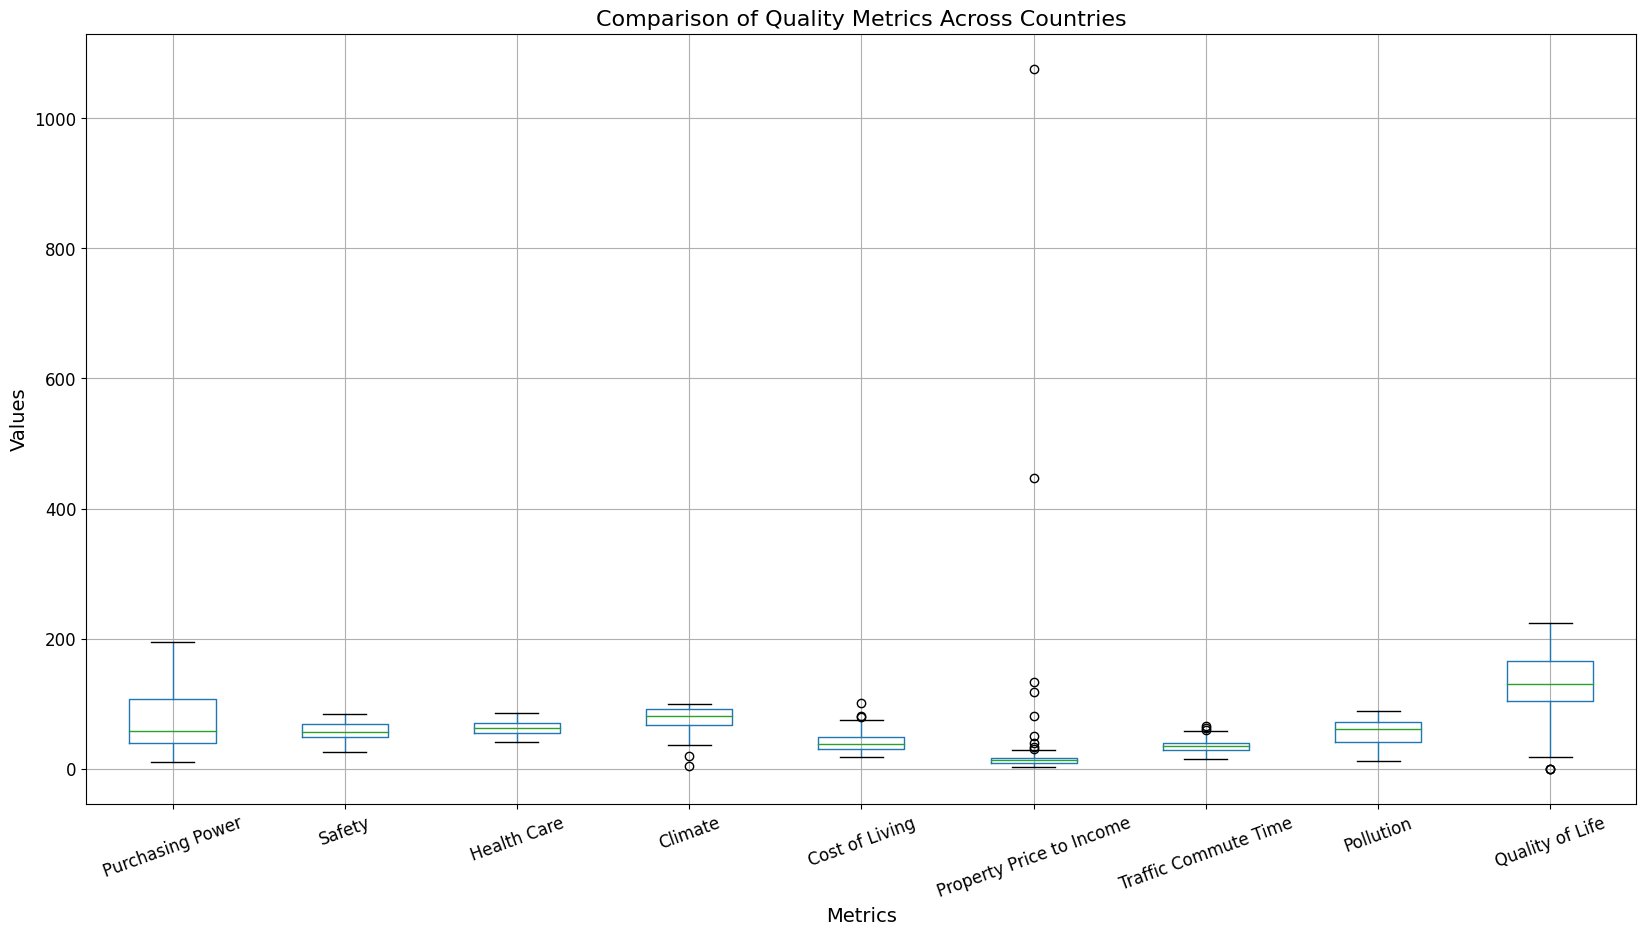

In [29]:
df.boxplot(figsize=(20,10))
# Customize the plot
plt.title("Comparison of Quality Metrics Across Countries", fontsize=16)
plt.ylabel("Values", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

Look into "Property Price to Income"

In [30]:
df["Property Price to Income"].sort_values().tail(10)

18       28.60
39       29.83
70       33.09
96       39.94
30       49.87
36       81.28
12      118.01
100     134.04
87      446.83
105    1075.92
Name: Property Price to Income, dtype: float64

Investigate the subset of the data with Property Price to Income Category labeled as "Very High"

In [31]:
df["Property Price to Income"][df["Property Price to Income"]<130].loc[df["Property Price to Income Category"] == "Very High"].describe()

count     33.000000
mean      27.177879
std       20.573309
min       16.000000
25%       17.850000
50%       20.890000
75%       25.590000
max      118.010000
Name: Property Price to Income, dtype: float64

In [32]:
df["Property Price to Income"].sort_values()

76        2.81
88        3.09
93        3.21
109       3.54
7         4.90
        ...   
36       81.28
12      118.01
100     134.04
87      446.83
105    1075.92
Name: Property Price to Income, Length: 114, dtype: float64

## Handling extremely high values

### Option A

Arguable idea is to systematically select and replace the values above a certain threshold, but to do it in such a way that preserves the order between them and all the other data points. The solution is to find the maximum value for all rows that would still be within the range of what we perceive as normal entries. Then we should find the highest value that isn't considered an outlier. The actual outliers should lie within that range, and to preserve their order, they should increase by an equal constant.

To achieve it, we compute the interquartile range, and arbitrarly - by trial and error - set the threshold for outliers, here Q3 + 1.5 IQR.
Next, everything equal or larger than that thershold is caught by saving the corresponding indices in a list.
Lower bound isn't the most fortunate name for this variable, but I didn't come up with anything better, in fact, the lower bound means the highest non-outlier value, so in essence it is the lower bound of the range we want our outliers to fall within.

An appropriate value for c is computed by dividing the difference between the upper and lower bound by number of values minus one.

Finally, the for loop assigns new values to the outliers/ the small value of 0.01 deduced from the upper bound is arbitrary, it has no meaning and serves only one purpose - to keep the highest value within the range.

**Its usefulness is entirely dependent on the naive assumption that the spotted outliers preserve the correct ordinal relationship, which may or may not be the case.**

In [33]:
# Calculate Q1, Q3, and IQR
Q1 = df["Property Price to Income"].quantile(0.25)
Q3 = df["Property Price to Income"].quantile(0.75)
IQR = Q3 - Q1

# Select outliers
upper_bound = Q3 + 1.5 * IQR
outliers = df["Property Price to Income"].loc[df["Property Price to Income"] >= upper_bound]
indices = outliers.sort_values(ascending=False).index.tolist()

# Ensure order is correct
print("Before transformation:")
print(df.loc[indices, ["Property Price to Income"]])  


# Compute lower_bound for the imputed values
lower_bound = df["Property Price to Income"].drop(indices).max()

# Compute the step size to ensure even spacing between the imputed values
try:
    n = len(indices)
    c = (upper_bound - lower_bound) / (n - 1) if n>1 else 0

    # Impute values in an increasing sequence
    for pos, i in enumerate(indices): 
        df.loc[i, "Property Price to Income"] = round((lower_bound-0.01) + (n-(pos+1)) * c, 2)

except ZeroDivisionError:
    df.loc[indices[0], "Property Price to Income"] = round(upper_bound-0.01, 2)

# Check updated values
print(f"\nupper bound: {round(upper_bound, 2)} \nlower bound: {lower_bound} \nc: {round(c, 2)} \nn: {n} \n")


print("After transformation:")
print(df.loc[indices, ["Property Price to Income"]])  # Check if order changed


Before transformation:
     Property Price to Income
105                   1075.92
87                     446.83
100                    134.04
12                     118.01
36                      81.28
30                      49.87
96                      39.94
70                      33.09
39                      29.83

upper bound: 29.37 
lower bound: 28.6 
c: 0.1 
n: 9 

After transformation:
     Property Price to Income
105                     29.36
87                      29.26
100                     29.17
12                      29.07
36                      28.98
30                      28.88
96                      28.78
70                      28.69
39                      28.59


### Option B
Alternatively, if we decide that the original order is insignificant, we may go with a simpler option to clip values at a certain boundary. 
Here, we use the same threshold as previously, Q3 + 1.5 IQR, and all the values higher than that are capped at the threshold value. 

In [34]:
# # Calculate Q1, Q3, and IQR
# Q1 = df["Property Price to Income"].quantile(0.25)
# Q3 = df["Property Price to Income"].quantile(0.75)
# IQR = Q3 - Q1

# # Define lower and upper bounds for outlier detection
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = (Q3 + 1.5 * IQR) - 0.01

# # Cap Outliers (Replace extreme values with the nearest non-outlier)
# df["Property Price to Income"] = df["Property Price to Income"].clip(upper=upper_bound)


## Handling 0.0's

Next, there are some outliers with the Quality of Life index set at 0.0. 
While the quality of life might be very low in these countries, it's rather unlikely that 0 was the intended input in all these cases.
We should treat these values as missing.

In [35]:
df[df["Quality of Life"] == 0].select_dtypes(include="number")

,Purchasing Power,Safety,Health Care,Climate,Cost of Living,Property Price to Income,Traffic Commute Time,Pollution,Quality of Life
87,20.50,72.81,72.87,99.74,37.05,29.26,15.67,39.22,0.0
100,23.52,46.46,42.14,71.28,25.31,29.17,27.79,62.48,0.0
105,10.33,45.88,50.05,98.41,47.97,29.36,44.50,84.05,0.0


### Regression model
We can assume a linear relationship between the quality of life and the other features, as the quality of life index will likely be the outcome of a combination of the other, measurable, qualities. Thus we can try to predict it with a linear regression model.

#### Model training & evaluation

In [36]:
X = df.loc[df["Quality of Life"] != 0].select_dtypes(include="number").drop(columns="Quality of Life")
y = df.loc[df["Quality of Life"] != 0, ["Quality of Life"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)

regressor = LinearRegression().fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 23.02
Coefficient of determination: 0.98


#### Predicting the values in question

In [37]:
df.loc[df["Quality of Life"] == 0, "Quality of Life"] = regressor.predict(df.loc[df["Quality of Life"] == 0].select_dtypes(include="number").drop(columns="Quality of Life"))

In [38]:
df["Quality of Life"].sort_values()
df.loc[df["Quality of Life Category"] == 'Very Low', "Quality of Life"].describe()

count     26.000000
mean      79.168100
std       23.616230
min       17.470000
25%       67.315143
50%       85.415000
75%       96.262500
max      122.666924
Name: Quality of Life, dtype: float64

#### Some extra check

In [39]:
errdf = []
for i in range(df.shape[0]):
    value = df.loc[i, "Quality of Life"]
    prediction = regressor.predict(df.select_dtypes(include='number').drop(columns="Quality of Life").loc[[i]])
    diff = abs(value - prediction)
    if diff >= 20:
        errdf.append({i:diff[0][0]})

print(errdf)
indx = [list(x.keys())[0] for x in errdf]


temp = df.loc[indx].copy()
temp["Prediction"] = regressor.predict(temp.select_dtypes(include='number').drop(columns="Quality of Life"))
train_preds = regressor.predict(X_train)
test_preds = regressor.predict(X_test)
print("Train R²:", r2_score(y_train, train_preds))
print("Test R²:", r2_score(y_test, test_preds))
temp

[{12: 66.06811735952498}, {36: 39.38848239222799}]
Train R²: 0.9493632895557192
Test R²: 0.9846100183439842


,Country,Purchasing Power,Purchasing Power Category,Safety,Safety Category,Health Care,Health Care Category,Climate,Climate Category,Cost of Living,Cost of Living Category,Property Price to Income,Property Price to Income Category,Traffic Commute Time,Traffic Commute Time Category,Pollution,Pollution Category,Quality of Life,Quality of Life Category,Prediction
12,Botswana,64.6,Moderate,47.30,Moderate,61.12,High,88.87,Very High,40.05,Low,29.07,Very High,28.53,Low,46.09,Moderate,36.55,Very Low,102.618117
36,Ghana,17.4,Very Low,54.65,Moderate,57.38,Moderate,67.03,High,30.49,Very Low,28.98,Very High,39.67,Moderate,86.91,Very High,17.47,Very Low,56.858482


In [40]:
df.describe()

,Purchasing Power,Safety,Health Care,Climate,Cost of Living,Property Price to Income,Traffic Commute Time,Pollution,Quality of Life
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,72.673421,57.905789,62.604298,77.896930,41.411053,14.181754,35.434649,56.154649,133.518251
std,42.417819,13.601773,10.202121,17.358836,15.366051,6.764495,9.407027,19.970989,42.440721
min,10.330000,25.360000,41.050000,3.540000,17.900000,2.810000,15.670000,11.830000,17.470000
25%,40.285000,48.192500,55.245000,67.977500,29.930000,9.145000,28.662500,40.950000,105.507500
50%,57.920000,57.005000,62.110000,80.600000,37.925000,12.905000,35.175000,60.465000,129.720000
75%,107.965000,68.230000,71.072500,91.692500,49.422500,17.235000,40.375000,72.177500,164.945000
max,195.550000,84.430000,86.500000,99.890000,101.180000,29.360000,65.310000,89.410000,224.310000


## Check the outcomes

Plot the boxplots once again to see how the data changed after cleansing.

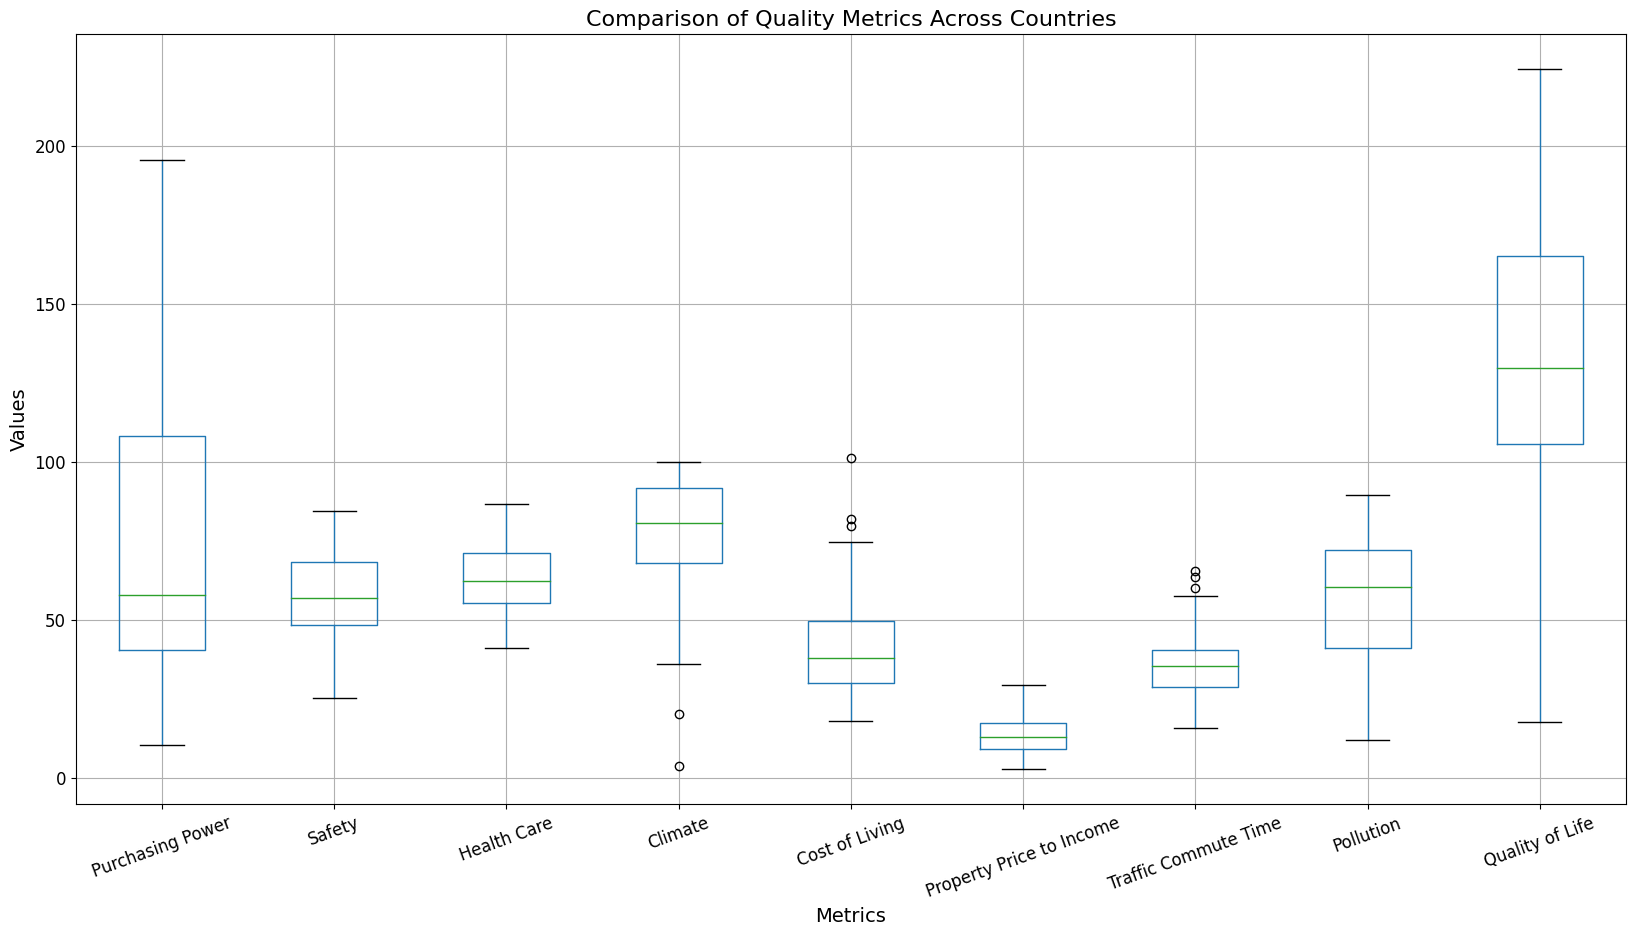

In [41]:
df.boxplot(figsize=(20,10))
# Customize the plot
plt.title("Comparison of Quality Metrics Across Countries", fontsize=16)
plt.ylabel("Values", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

### Manual inspections
Manually inspect all the categorical values. 

In [42]:
for col in df.select_dtypes(include='object').columns:
    print(df[col].unique())

['Albania' 'Algeria' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus' 'Belgium'
 'Bosnia And Herzegovina' 'Botswana' 'Brazil' 'Bulgaria' 'Cambodia'
 'Canada' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus'
 'Czech Republic' 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France' 'Georgia'
 'Germany' 'Ghana' 'Greece' 'Guatemala' 'Hong Kong (China)' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya'
 'Kosovo (Disputed Territory)' 'Kuwait' 'Kyrgyzstan' 'Latvia' 'Lebanon'
 'Libya' 'Lithuania' 'Luxembourg' 'Macao (China)' 'Malaysia' 'Malta'
 'Mexico' 'Moldova' 'Mongolia' 'Montenegro' 'Morocco' 'Nepal'
 'Netherlands' 'New Zealand' 'Nigeria' 'North Macedonia' 'Norway' 'Oman'
 'Pakistan' 'Panama' 'Paraguay' 'Peru' 'Philippines' 'Poland' 'Portugal'
 'Qatar' 'Romania' 'Russia' 'Rwanda' 'Saudi Arabia' 'Serbia' '

Manually inspect numerical values

In [43]:
df.select_dtypes(include='number').describe()

,Purchasing Power,Safety,Health Care,Climate,Cost of Living,Property Price to Income,Traffic Commute Time,Pollution,Quality of Life
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,72.673421,57.905789,62.604298,77.896930,41.411053,14.181754,35.434649,56.154649,133.518251
std,42.417819,13.601773,10.202121,17.358836,15.366051,6.764495,9.407027,19.970989,42.440721
min,10.330000,25.360000,41.050000,3.540000,17.900000,2.810000,15.670000,11.830000,17.470000
25%,40.285000,48.192500,55.245000,67.977500,29.930000,9.145000,28.662500,40.950000,105.507500
50%,57.920000,57.005000,62.110000,80.600000,37.925000,12.905000,35.175000,60.465000,129.720000
75%,107.965000,68.230000,71.072500,91.692500,49.422500,17.235000,40.375000,72.177500,164.945000
max,195.550000,84.430000,86.500000,99.890000,101.180000,29.360000,65.310000,89.410000,224.310000


## Why didn't we 'fix' other outliers?

### Let's see the 'others'

#### "Climate"

In [44]:
df["Climate"].sort_values().head()
#df["Climate"].loc[df["Climate Category"]=="Moderate"]

67     3.54
55    20.22
84    36.03
52    39.78
86    43.60
Name: Climate, dtype: float64

In [45]:
df.loc[[67, 55],["Climate", "Climate Category", "Country"]]

,Climate,Climate Category,Country
67,3.54,Low,Mongolia
55,20.22,Moderate,Kuwait


#### "Cost of Living"

In [61]:
df["Cost of Living"].sort_values().tail()

75     71.27
39     74.59
90     79.72
41     81.71
98    101.18
Name: Cost of Living, dtype: float64

In [47]:
df.loc[[98, 41, 90],["Country"]]

,Country
98,Switzerland
41,Iceland
90,Singapore


These three countries are commonly known to be among the most expensive places in the world to live in.

#### "Property Price to Income"

In [48]:
df["Property Price to Income"].sort_values().tail(10)

39     28.59
18     28.60
70     28.69
96     28.78
30     28.88
36     28.98
12     29.07
100    29.17
87     29.26
105    29.36
Name: Property Price to Income, dtype: float64

In [49]:
df.loc[[12, 100, 87, 105, 36],["Country", "Purchasing Power", "Cost of Living", "Property Price to Income"]]

,Country,Purchasing Power,Cost of Living,Property Price to Income
12,Botswana,64.60,40.05,29.07
100,Tanzania,23.52,25.31,29.17
87,Rwanda,20.50,37.05,29.26
105,Uganda,10.33,47.97,29.36
36,Ghana,17.40,30.49,28.98


We can suspect this relatively high cost of living combined with rather low purchasing power would reflect in the property price to income index.
Without vast domain knowledge, the best approach is to assume these values are correct. We should also keep in mind that the dataset doesn't contain all the countries in the world, and thus the outliers we investigate might have turned out to be located perfectly within the standard boundaries if we've had collected information from more countries.

#### "Traffic Commute Time"

In [50]:
df["Traffic Commute Time"].sort_values().tail(10)

27     48.10
80     49.78
38     50.58
53     50.59
96     54.52
102    56.88
8      57.57
20     59.99
30     63.36
73     65.31
Name: Traffic Commute Time, dtype: float64

In [51]:
df.loc[[73,30,20,8,102],["Country"]]

,Country
73,Nigeria
30,Ethiopia
20,Costa Rica
8,Bangladesh
102,Trinidad And Tobago


Again, this is just a bold assumption, but we might think the countries with the highest commute time are not the highest developed countries, and thus their road infrastructure, as well as public transport are not the best. Hence, people spend much more time on daily commute.

### Conclusion

Prevalence of outliers is normal and it doesn't always indicate an error.
What makes a point an outlier is relative, as we collect more data the outliers might not stand out anymore and become just standard entries.
It is crucial to handle outliers with care and not to remove them at all costs.